In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from skimage import measure
import matplotlib.lines as mlines
import sys 
sys.path.append("../../lib")
from figparams import *
plt.rcParams.update(rc_params)
from defaults import *
freq = np.arange(fmin, fmax, df)
long_size = [2*fig_width, fig_height]



In [2]:
def get_contour(file, statistics = 'BF'):
    data = np.loadtxt(file)
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        rho = [34, 100, 1000]
        # Create a grid for interpolation
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]  # create a grid
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')  # interpolate values
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y
    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')  # interpolate values
        bounds = [ 0.5, 1,  2]
        pls_bayes_10= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes_10.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))
        return pls_bayes_10, cont_x, cont_y
    
pls_bayes_nu10, x_coords7, y_coords7 = get_contour('../../data/pls_data_nu10.txt')
pls_bayes_nu10_05nc, x_coords8, y_coords8 = get_contour('../../data/pls_data_nu10_05nc.txt')
pls_bayes_nu10_01nc, x_coords10, y_coords10 = get_contour('../../data/pls_data_nu10_01nc.txt')
pls_snr, x_coords7_, y_coords7_ = get_contour('../../data/pls_data_nu10.txt', 'SNR')
pls_snr_nc05, x_coords8_, y_coords8_ = get_contour('../../data/pls_data_nu10_05nc.txt', 'SNR')
pls_snr_nc01, x_coords10_, y_coords10_ = get_contour('../../data/pls_data_nu10_01nc.txt', 'SNR')



In [3]:
def Stm(f):
    c = 3*1e8
    A = 3
    return A**2*10**(-30)*(1 + (0.4*10**-3/f)**2)*(1 + (f/(8*10**-3))**4)*(1/(2*np.pi*f*c)**2) 
def Soms(f):
    c = 3*1e8
    P = 15
    return P**2*10**(-24)*(1 + (2*10**-3/f)**4)*(2*np.pi*f/c)**2
def signal(f, Om_amp, gamma):
    f0 = 10**-2.5
    L = 8.3
    r = 0.2*384*(L*np.pi*f)**4
    H02 = (69.8*1e3/ (3.08 * 1e22))**2
    return r*(10**Om_amp*(f/f0)**gamma)*3*H02/(4*np.pi**2*f**3)

In [4]:
def SNR_AET(freq, signal, dof_used, include = False, **kwargs):
        Tobs = 4*yearinseconds     
        L = 8.3   
        T = dof_used*(Tobs / 1000)
        H02 = (69.8*1e3/ (3.08 * 1e22))**2
        Raa = 1.5*0.2*384*(L*np.pi*freq)**4
        Rtt = 256*(freq*L*np.pi)**10/63
        if signal == 'power_law':
            f0 = 10**(-2.5)#np.sqrt(fmin*fmax)
            amp = kwargs.get('amp')
            gamma = kwargs.get('gamma')
            S = (10**amp*(freq/f0)**gamma)*3*H02/(4*np.pi**2*freq**3)
        if signal == 'bump':
            amp = kwargs.get('amp')
            sigma = kwargs.get('sigma')
            f0 = kwargs.get('f0')
            S = (10**amp*np.exp(-np.log10(freq / 10**f0 )**2 / sigma**2))*3*H02/(4*np.pi**2*freq**3)
        if signal == 'broken_power_law':
            f0 = 10**(-2.5)#np.sqrt(fmin*fmax)
            amp = kwargs.get('amp')
            gamma1 = kwargs.get('gamma1')
            gamma2 = kwargs.get('gamma2')
            S = (10**amp*(freq/f0)**gamma1*(1 + (freq/f0)**(gamma2 - gamma1)))*3*H02/(4*np.pi**2*freq**3)
        Sa = Raa*S
        Se = Sa
        St = Rtt*S
        Na = 8*np.sin(2*np.pi*freq*L)**2*(Soms(freq)*(np.cos(2*np.pi*freq*L) + 2) + 2*(3 + 2*np.cos(2*np.pi*freq*L) + np.cos(4*np.pi*freq*L))*Stm(freq))
        Nt = 6*(Soms(freq) + 2*(1 - np.cos(2*np.pi*freq*L))*Stm(freq))
        if include == True:
            Na += Sa
            Nt += St
        integral = np.sum((Sa / Na)**2)*T*(freq[1] - freq[0]) + np.sum((Se / Na)**2)*T*(freq[1] - freq[0]) + np.sum((St / Nt)**2)*T*(freq[1] - freq[0])
        return integral**0.5


def get_pls(freq, threshold, dof_used):
        Tobs = 4*yearinseconds     
        L = 8.3   
        T = dof_used*(Tobs / 1000)
        H02 = (69.8*1e3/ (3.08 * 1e22))**2
        Raa = 1.5*0.2*384*(L*np.pi*freq)**4
        Rtt = 256*(freq*L*np.pi)**10/63  
        f0 = 10**(-2.5)#np.sqrt(fmin*fmax)
        g = np.linspace(-4,4,20)
        curve = []
        for i in range(20):
            gamma = g[i]
            S = ((freq/f0)**gamma)*3*H02/(4*np.pi**2*freq**3)   
            Sa = Raa*S
            Se = Sa
            St = Rtt*S
            Na = 8*np.sin(2*np.pi*freq*L)**2*(Soms(freq)*(np.cos(2*np.pi*freq*L) + 2) + 2*(3 + 2*np.cos(2*np.pi*freq*L) + np.cos(4*np.pi*freq*L))*Stm(freq))
            Nt = 6*(Soms(freq) + 2*(1 - np.cos(2*np.pi*freq*L))*Stm(freq))
            integral = np.sum((Sa / Na)**2)*T*(freq[1] - freq[0]) + np.sum((Se / Na)**2)*T*(freq[1] - freq[0]) + np.sum((St / Nt)**2)*T*(freq[1] - freq[0])
            amp = threshold / integral**0.5
            curve.append(amp*(freq/f0)**gamma)
        pls_snr = (np.max(curve,axis=0)*(0.67)**2)
        return pls_snr


In [5]:
def get_contour_new(file, freq, SNR = None, statistics = 'BF'):
    data = np.loadtxt(file)
    f0 = 10**-2.5
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        snr = SNR
        rho = [10]
        grid_x, grid_y = np.mgrid[np.min(G):np.max(G):500j, np.min(A):np.max(A):500j]
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y

    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[np.min(G):np.max(G):500j, np.min(A):np.max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')  # interpolate values
        bounds = [ 0.5, 1,  2]
        pls_bayes= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))    
        return pls_bayes, cont_x, cont_y

In [6]:
amp_snr = []
for i in range(10):
    pls_ = get_pls(freq=freq, threshold=34, dof_used=(i+1)*100)
    ind = np.argmin(np.abs(freq -10**-2.5))
    amp_snr.append(pls_[ind])
    
amp_bf = []
for i in range(10):
    pls_bayes_7, x_coords7, y_coords7 = get_contour_new('../../data/pls_time_data/pls_pls_0%i.txt'%(i+1), freq=freq)
    ind = np.argmin(np.abs(freq -10**-2.5))
    amp_bf.append(pls_bayes_7[1][ind])

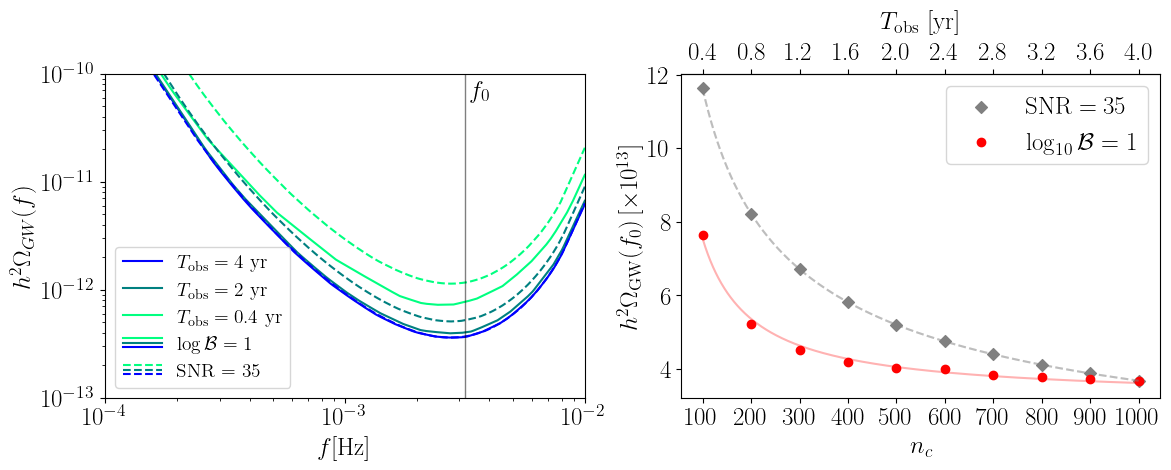

In [7]:
legend_plots = []
cmap = plt.get_cmap('winter')
db = cmap(0.0)   # Dark blue
teal = cmap(0.5)   # Teal
lg = cmap(1.0)  # Light green
bounds = [0.5, 1, 2]
rho = [34, 100, 1000]


# Figure with two subplots and no shared axes 
fig, axs = plt.subplots(1, 2, figsize=long_size)

# Set current axis to axs[0]
plt.sca(axs[0])

for i in range(len(bounds)):
    if bounds[i] == 1:
        leg_a = plt.loglog(freq, pls_bayes_nu10[i][:],c = db, label = r'$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
        leg_b = plt.loglog(freq, pls_bayes_nu10_05nc[i][:],c = 'teal', label = r'$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
        leg_c = plt.loglog(freq, pls_bayes_nu10_01nc[i][:],c = lg, label = r'$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
for i in range(len(rho)):
    if rho[i] == 34:
        leg_d = plt.loglog(freq, pls_snr[i][:], c = db, linestyle = '--',label = 'SNR = %.1f'%rho[i])
        leg_e = plt.loglog(freq, pls_snr_nc05[i][:], c = 'teal', linestyle = '--',label = 'SNR = %.1f'%rho[i])
        leg_f = plt.loglog(freq, pls_snr_nc01[i][:], c = lg, linestyle = '--',label = 'SNR = %.1f'%rho[i])
legend_plots.append(leg_a)
legend_plots.append(leg_b)
legend_plots.append(leg_c)
legend_plots.append(leg_d)
legend_plots.append(leg_e)
legend_plots.append(leg_f)
plt.xlabel(r'$f \rm{[Hz]}$')
plt.ylabel(r'$h^2\Omega_{GW}(f)$')
plt.axvline(10**-2.5, c = 'k',alpha = 0.5,linewidth=1)
plt.annotate("$f_0$", xy=(1.05*10**-2.5, 0.6*10**-10))
continuous_line = mlines.Line2D([], [], color='k', alpha = 0.5, label=r'$\\log_{10}{\cal B} = 1$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', alpha = 0.5, label='${\\rm SNR} = 35$', linestyle='--')
bpline = mlines.Line2D([], [], color=db, label=r'$T_{\rm obs} = 4$ yr')
rpline = mlines.Line2D([], [], color='teal', label=r'$T_{\rm obs} = 2$ yr')
gpline = mlines.Line2D([], [], color=lg, label=r'$T_{\rm obs} = 0.4$ yr')
custom_lines_BF = [mlines.Line2D([0], [0], color=db, linestyle='-'),
                   mlines.Line2D([0], [0], color='teal', linestyle='-'),
                   mlines.Line2D([0], [0], color=lg, linestyle='-')]
custom_lines_SNR = [mlines.Line2D([0], [0], color=db, linestyle='--'),
                   mlines.Line2D([0], [0], color='teal', linestyle='--'),
                   mlines.Line2D([0], [0], color=lg, linestyle='--')]
plt.legend([bpline,
            rpline,
            gpline,
            (custom_lines_BF[0], custom_lines_BF[1], custom_lines_BF[2]),
            (custom_lines_SNR[0], custom_lines_SNR[1], custom_lines_SNR[2])],
          [r"$T_{\rm obs} = 4$ yr", 
           r"$T_{\rm obs} = 2$ yr",
           r"$T_{\rm obs} = 0.4$ yr",
           r'$\log{\cal B} = 1$',
           'SNR = 35'], 
          handler_map={tuple: HandlerVerticalLines()}, 
          loc='lower left', fontsize=14)
plt.xlim(10**-4,10**-2)
plt.ylim(10**-13,10**-10)


# Set current axis to axs[1]
plt.sca(axs[1])

x_data = np.linspace(0.1,1,10)*1000  
##########################################################
def log_model(x, a, b, c):
    return a * x / (c + x)   + b
# Perform the curve fitting
params, covariance = curve_fit(log_model, x_data, amp_bf)
a, b, c = params 
y_fit = log_model(np.linspace(0.1,1,1000)*1000, a, b, c)
##########################################################
def root(x, a, b):
    return a  / np.sqrt(b*x)

params, covariance = curve_fit(root, x_data, amp_snr)
a, b = params  
y_fit_snr = root(np.linspace(0.1,1,1000)*1000, a, b)

ax = fig.gca()
ax.scatter(x_data, np.array(amp_snr)*1e13, c='grey', marker = 'D', label="$\\rm{SNR} = 35$")
ax.scatter(x_data, np.array(amp_bf)*1e13, c='red', label=r"$\log_{10}\mathcal{B} = 1$")
ax.plot(np.linspace(0.1,1,1000)*1000, y_fit_snr*1e13, color="grey", ls='dashed', alpha = 0.3)
ax.plot(np.linspace(0.1,1,1000)*1000, y_fit*1e13, color="red", alpha = 0.3)
ax.plot(np.linspace(0.1,1,1000)*1000, y_fit_snr*1e13, color="grey", ls='dashed', alpha = 0.3)
ax.set_xlabel("$n_c$")
ax.set_xticks(np.linspace(0.1,1,10)*1000, np.array(np.linspace(0.1,1,10)*1000, dtype=int))
ax.set_ylabel(r"$h^2\Omega_{\rm{GW}}(f_0) \, [\times 10^{13}]$")
ax.legend(loc = 'upper right')
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'$T_{\rm{obs}}$ [yr]', labelpad=10)
secax.set_xticks(np.linspace(0.1,1,10)*1000, np.round(np.linspace(0.1,1,10)*1000/df / yearinseconds,1))


plt.savefig('../../plots/Figure3.pdf',bbox_inches='tight')